# HW5 - LSTM and GRU

## README
In Main:
1. Change path to your /path/to/data/names/*.txt.
2. The selected parameters are in the params variable.

## Import

In [29]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd './gdrive/My Drive'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: './gdrive/My Drive'
/content/gdrive/My Drive


## Data

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [0]:
class NameDataset(Dataset):
    """Dataloader class for the dataset."""
    def __init__(self, name_txt_dir, data_type='train', data_split=0.8):
        """
        Summary:
            Initialise Dataloader class.
        Args:
            name_txt_dir (string): Path to the name text files.
            data_type (string): "train", "val", or "test" (if available).
            data_split (float): Train/test split.
        """
        assert data_type == 'train' or data_type == 'val'
        assert type(data_split) == float

        self.all_letters = string.ascii_letters + " .,;'"
        self.n_letters = len(self.all_letters)
        # Build the category_lines dictionary, a list of names per language
        self.category_lines = {}
        self.all_categories = []
        for filename in self.find_files(name_txt_dir):
            self.category = os.path.splitext(os.path.basename(filename))[0]
            self.all_categories.append(self.category)
            self.lines = self.read_lines(filename)
            split_idx = int(len(self.lines) * data_split)
            if data_type == 'train':
                self.category_lines[self.category] = self.lines[:split_idx]
            elif data_type == 'val':
                self.category_lines[self.category] = self.lines[split_idx:]
        self.n_categories = len(self.all_categories)

        self.data_type = data_type

        self.x, self.y = self.create_dataset()

    def __len__(self):
        """
        Returns:
            integer: Total number of samples.
        """
        return len(self.x)

    def __getitem__(self, idx):
        """
        Summary:
            Prepares data to be retrieved.
        Args:
            idx (integer): Index of sample to be predicted.
        Returns:
            dictionary: Tensor and label of one sample.
        """
        line = self.x[idx]
        label = self.y[idx]
        
        sample = {'line': line, 'label': label}
        
        return sample

    def find_files(self, path):
        """
        Summary:
            Get files in 'path'.
        Args:
            path (string): Path to look for files in.
        Returns:
            list: Files in 'path'.
        """
        return glob.glob(path)

    def unicode_to_ascii(self, s):
        """
        Summary:
            Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427.
        Args:
            s (string): Unicode string.
        Returns:
            string: Plain ASCII of 's'.
        """
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
            and c in self.all_letters
        )

    def read_lines(self, filename):
        """
        Summary:
            Read a file and split into lines.
        Args:
            filename (string): File path to read from.
        Returns:
            list: Plain ASCII strings of lines in file.
        """
        lines = open(filename, encoding='utf-8').read().strip().split('\n')
        return [self.unicode_to_ascii(line) for line in lines]

    def create_dataset(self):
        """
        Summary: 
            Get a list of tensors for all names and a list of corresponding labels.
        Returns:
            list of strings: All tensors of all names.
            NumPy array of torch.long: All labels for all images.
        """
        x = []
        y = []
        for cat in self.all_categories:
            category_tensor = torch.tensor([self.all_categories.index(cat)], dtype=torch.long)
            for line in self.category_lines[cat]:
                line_tensor = self.line_to_tensor(line)
                x.append(line_tensor)
                y.append(category_tensor)
        return x, y

    def line_to_tensor(self, line):
        """
        Summary:
            Convert name to Tensor.
        Args:
            line (string): Name to convert to Tensor.
        Returns:
            Tensor: 2D matrix of one-hot vectors, for a size of  <line_length x 1 x n_letters>, extra 1 dimension is batch size.
        """
        tensor = torch.zeros(len(line), 1, self.n_letters)
        for li, letter in enumerate(line):
            tensor[li][0][self.letter_to_index(letter)] = 1
        return tensor

    def letter_to_index(self, letter):
        """
        Summary:
            Find letter index from self.all_letters, e.g. "a" = 0
        Args:
            letter (string): A letter.
        Returns:
            integer: Index of letter from self.all_letters.
        """
        return self.all_letters.find(letter)

## LSTM and GRU





In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Summary:
            Create LSTM model.
        Args:
            input_size (integer): Input size for LSTM.
            hidden_size (integer): Hidden state size for LSTM.
            num_layers (integer): Number of layers for LSTM.
            output_size (integer): Output size for LSTM.
        """
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        """
        Summary:
            Forward pass.
        Args:
            x (Tensor): Input word.
        Returns:
            Tensor: Softmax output.
        """
        batch_size = list(x.size())[1]
        h0, c0 = self.init_memory_and_hidden(batch_size)
        _, (hn, cn) = self.lstm(x, (h0, c0))
        output = self.fc(hn)
        output = self.softmax(output)

        return output

    def init_memory_and_hidden(self, batch_size):
        """
        Summary:
            Initialise zero cell and hidden state for LSTM.
        Args:
            batch_size (integer): Batch size for training.
        Returns:
            Tensor: Zero Tensor for LSTM initial cell state.
            Tensor: Zero Tensor for LSTM initial hidden state.
        """
        return torch.zeros(self.num_layers, batch_size, self.hidden_size), torch.zeros(self.num_layers, batch_size, self.hidden_size)

    def train_model(self, criterion, optimizer, line_tensors, category_tensors):
        """
        Summary:
            Model training.
        Args:
            criterion (torch.nn.modules.loss.NLLLoss): Loss function.
            optimizer (torch.optim.sgd.SGD): Optimizer for model.
            line_tensors (Tensor): Input word(s).
            category_tensors (Tensor): Input label(s).
        Returns:
            Tensor: Softmax output from model.
            float: Loss from training.
        """
        optimizer.zero_grad()
        output = self(line_tensors)[0]
        loss = criterion(output, category_tensors)
        loss.backward()
        optimizer.step()

        return output, loss.item()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Summary:
            Create GRU model.
        Args:
            input_size (integer): Input size for GRU.
            hidden_size (integer): Hidden state size for GRU.
            num_layers (integer): Number of layers for GRU.
            output_size (integer): Output size for GRU.
        """
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, x):
        """
        Summary:
            Forward pass.
        Args:
            x (Tensor): Input word.
        Returns:
            Tensor: Softmax output.
        """
        batch_size = list(x.size())[1]
        h0 = self.init_hidden(batch_size)
        _, hn = self.gru(x, h0)
        output = self.fc(hn)
        output = self.softmax(output)

        return output

    def init_hidden(self, batch_size):
        """
        Summary:
            Initialise hidden state for GRU.
        Args:
            batch_size (integer): Batch size for training.
        Returns:
            Tensor: Zero Tensor for GRU initial hidden state.
        """
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)
    
    def train_model(self, criterion, optimizer, line_tensors, category_tensors):
        """
        Summary:
            Model training.
        Args:
            criterion (torch.nn.modules.loss.NLLLoss): Loss function.
            optimizer (torch.optim.sgd.SGD): Optimizer for model.
            line_tensors (Tensor): Input word(s).
            category_tensors (Tensor): Input label(s).
        Returns:
            Tensor: Softmax output from model.
            float: Loss from training.
        """
        optimizer.zero_grad()
        output = self(line_tensors)[0]
        loss = criterion(output, category_tensors)
        loss.backward()
        optimizer.step()

        return output, loss.item()

## Tasks

In [0]:
def pad_collate(batch):
    """
    Summary:
        Pad sequences for batch_size > 1.
    Args:
        batch ()
    Returns:
        list: Contains list of name data Tensors and their target labels.
    """
    data = [torch.squeeze(item['line'],dim=1) for item in batch]
    data = torch.nn.utils.rnn.pad_sequence(data, batch_first=False)
    targets = [item['label'] for item in batch]

    return [data, targets]

def run_experiment(model, criterion, trainloader, valloader, params):
    """
    Summary:
        Run experiments, where parameters can be customised.
    Args:
        model
        criterion
        trainloader
        valloader
        params
    """
    # Train
    optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.005)
    epochs = []
    train_loss = []
    test_loss = []
    all_test_acc = []

    print('Training for ' + str(params) + '...')
    for e in range(params['num_epoch']):
        model.train()
        current_loss = 0
        batch_count = 0
        for t in trainloader:
            line_tensors = t[0]
            category_tensors = torch.tensor(t[1], dtype=torch.long)
            output, loss = model.train_model(criterion, optimizer, line_tensors, category_tensors)
            current_loss += loss
            batch_count += 1
        avg_train_loss = current_loss / batch_count

        with torch.no_grad():
            current_loss = 0
            correct = 0
            count = 0
            batch_count = 0
            for v in valloader:
                line_tensors = v[0]
                category_tensors = torch.tensor(v[1], dtype=torch.long)
                output = model(line_tensors)[0]
                loss = criterion(output, category_tensors)
                current_loss += loss.item()

                size = list(category_tensors.shape)[0]
                count += size
                correct += torch.sum(category_tensors == torch.argmax(output,dim=1)).item()
                batch_count += 1
            test_acc = correct / count
            avg_test_loss = current_loss / batch_count

            print('Epoch ' + str(e + 1) + ' --> train loss: ' + str(avg_train_loss) + ', test loss: ' + str(avg_test_loss) + ', test acc: ' + str(test_acc))
            epochs.append(e+1)
            train_loss.append(avg_train_loss)
            test_loss.append(avg_test_loss)
            all_test_acc.append(test_acc)

    # Plot
    if params['plot']:
        plt.plot(epochs, train_loss, label='Train Loss')
        plt.plot(epochs, test_loss, label='Test Loss')
        plt.plot(epochs, all_test_acc, label='Test Accuracy')
        plt.legend(loc='best')
        plt.xlabel('Epoch')
        plt.savefig(str(params))
        plt.show()

    print('\n')

## Main

Training for {'model_type': 'lstm', 'n_hidden': 100, 'num_layers': 1, 'batch_size': 1, 'num_epoch': 5, 'plot': False}...
Epoch 1 --> train loss: 1.2813133692211784, test loss: 1.1328473460703674, test acc: 0.6438696841581696
Epoch 2 --> train loss: 0.9506601626654719, test loss: 1.1833579299674604, test acc: 0.6525739865705048
Epoch 3 --> train loss: 0.8231889713727771, test loss: 0.9838098130753148, test acc: 0.7057945784630689
Epoch 4 --> train loss: 0.7245629537932246, test loss: 1.1973985664788502, test acc: 0.6724695349415568
Epoch 5 --> train loss: 0.6479660751736391, test loss: 0.9931924538920939, test acc: 0.7212136284506342


Training for {'model_type': 'lstm', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 1, 'num_epoch': 5, 'plot': False}...
Epoch 1 --> train loss: 1.2933972356596468, test loss: 1.3073426443589158, test acc: 0.6120368067644865
Epoch 2 --> train loss: 0.9761361901653518, test loss: 1.1372249114674091, test acc: 0.6674956478487938
Epoch 3 --> train loss: 0.84

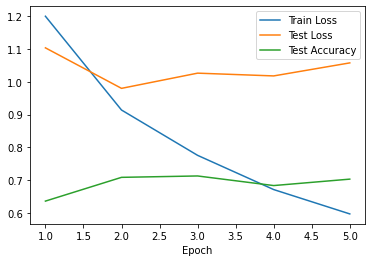



Training for {'model_type': 'gru', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 10, 'num_epoch': 5, 'plot': True}...
Epoch 1 --> train loss: 1.7684409705502158, test loss: 1.5618513607357631, test acc: 0.5244963939318578
Epoch 2 --> train loss: 1.5490022550150289, test loss: 1.5186019893689429, test acc: 0.5448893310121861
Epoch 3 --> train loss: 1.457994907941312, test loss: 1.389988748703346, test acc: 0.5824421785625467
Epoch 4 --> train loss: 1.3572818707503091, test loss: 1.5861831759992369, test acc: 0.531459835861726
Epoch 5 --> train loss: 1.301143134423389, test loss: 1.3541482043436384, test acc: 0.5854265108182044


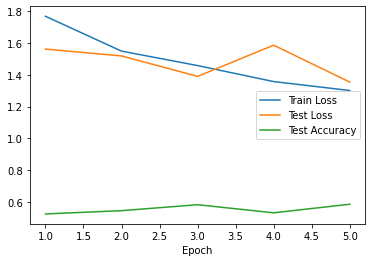



Training for {'model_type': 'gru', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 30, 'num_epoch': 5, 'plot': True}...
Epoch 1 --> train loss: 1.9193480756523005, test loss: 1.8320115937127008, test acc: 0.46804277542899775
Epoch 2 --> train loss: 1.8235466280090276, test loss: 1.7969838168885972, test acc: 0.46804277542899775
Epoch 3 --> train loss: 1.6741375100256792, test loss: 1.5996873289346696, test acc: 0.5142999253916936
Epoch 4 --> train loss: 1.569183523419188, test loss: 1.5883591480277204, test acc: 0.5110668987813977
Epoch 5 --> train loss: 1.5350470856499316, test loss: 1.5621067765686247, test acc: 0.5336980850534693


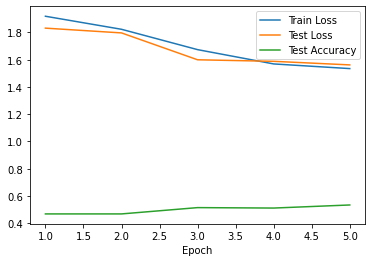

In [33]:
if __name__ == '__main__':
    # TODO: Change this path to your /path/to/data/names/*.txt
    path = 'data/names/*.txt'
    # For the loss function 'nn.NLLLoss' is appropriate, since the last layer of the networks is 'nn.LogSoftmax'
    criterion = nn.NLLLoss()
    num_epoch = 5

    # Task parameters
    params = [
        {'model_type': 'lstm', 'n_hidden': 100, 'num_layers': 1, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': False},
        {'model_type': 'lstm', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': False},
        {'model_type': 'lstm', 'n_hidden': 100, 'num_layers': 2, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': False},
        {'model_type': 'lstm', 'n_hidden': 200, 'num_layers': 2, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': False},
        {'model_type': 'gru', 'n_hidden': 100, 'num_layers': 1, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': False},
        {'model_type': 'gru', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 1, 'num_epoch': num_epoch, 'plot': True},
        {'model_type': 'gru', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 10, 'num_epoch': num_epoch, 'plot': True},
        {'model_type': 'gru', 'n_hidden': 200, 'num_layers': 1, 'batch_size': 30, 'num_epoch': num_epoch, 'plot': True}
    ]

    for p in params:
        trainset = NameDataset(path, data_type='train')
        trainloader = DataLoader(trainset, batch_size=p['batch_size'], shuffle=True, collate_fn=pad_collate)
        n_letters = trainset.n_letters
        n_categories = trainset.n_categories
        valset = NameDataset(path, data_type='val')
        valloader = DataLoader(valset, batch_size=p['batch_size'], shuffle=False, collate_fn=pad_collate)
        if p['model_type'] == 'lstm':
            model = LSTM(n_letters, p['n_hidden'], p['num_layers'], n_categories)
        else:
            model = GRU(n_letters, p['n_hidden'], p['num_layers'], n_categories)

        run_experiment(model, criterion, trainloader, valloader, p)